### Проект по методам оптимизаций 

# The Kernel Trick and its Applications in Machine Learning

In [1]:
from IPython import display
display.display(display.HTML("<style>.container { width:100% !important; }</style>"))

In [145]:
from math import radians, cos, sin, asin, sqrt
import time
import json
from copy import deepcopy
import ast
import warnings
import types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_digits
from sklearn.datasets import make_circles, make_friedman1, make_friedman2, make_friedman3, make_hastie_10_2
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from enum import Enum

## Тестирование sklearn.svm 

In [8]:
digits = load_digits()

In [9]:
def plot_digit(digit, ax):
    ax.imshow(digit, cmap=plt.cm.gray_r, interpolation='nearest')

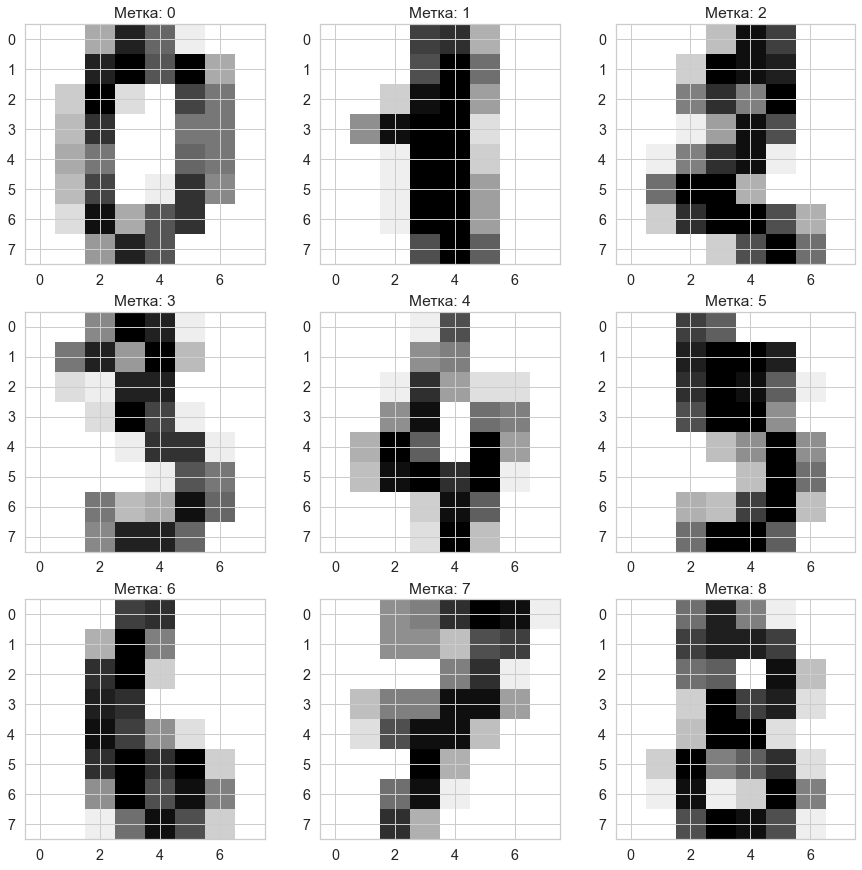

In [10]:
k = 3
_, axes = plt.subplots(k, k, figsize=(k * 5, k * 5))

for i in range(k):
    for j in range(k):
        ax = axes[i][j]
        idx = i * k + j
        plot_digit(digits['data'][idx].reshape(8, 8), ax)
        ax.set_title(f'Метка: {digits.target[idx]}')

plt.show()

In [45]:
X = normalize(digits.data)
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [176]:
def test_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    result = accuracy_score(y_test, y_test_predicted)
    return result

In [64]:
models_to_test = {
    'svm': svm.SVC(decision_function_shape="ovo", random_state=42),
    'random_forest': RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42),
    'logistic_regression': LogisticRegression(random_state=42),
    'naive_bayes': MultinomialNB(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

for model_name in models_to_test:
    model_to_test = models_to_test[model_name]
    print(f'Точность {model_name}: {test_model(X_train, X_test, y_train, y_test, model_to_test)}')

Точность svm: 0.9833101529902643
Точность random_forest: 0.9318497913769124
Точность logistic_regression: 0.9360222531293463
Точность naive_bayes: 0.9123783031988874
Точность KNeighborsClassifier: 0.9763560500695411


In [179]:
kernels_to_test = ['linear', 'poly', 'rbf']

models_to_test = {
    f'svm ({kernel})': svm.SVC(kernel=kernel) for kernel in kernels_to_test
}

for model_name in models_to_test:
    model_to_test = models_to_test[model_name]
    print(f'Точность {model_name}: {test_model(X_train, X_test, y_train, y_test, model_to_test)}')

Точность svm (linear): 0.9666203059805285
Точность svm (poly): 0.9847009735744089
Точность svm (rbf): 0.9833101529902643


## Реализация SVM

In [219]:
def plot_data(X, y, title, figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.title(title, fontsize=18)
    indices_true = (y == 1)
    indices_false = (y == -1)
    if X.shape[1] == 2:
        ax.scatter(X[indices_true, 0], X[indices_true, 1], c='r', label='label = $1$')
        ax.scatter(X[indices_false, 0], X[indices_false, 1], c='b', label='label = $-1$')
    elif X.shape[1] == 3:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X[indices_true, 0], X[indices_true, 1],  X[indices_true, 2], c='r', label='label = $1$')
        ax.scatter(X[indices_false, 0], X[indices_false, 1], X[indices_false, 2], c='b', label='label = $-1$')
        ax.set_zlabel('feature 2', fontsize=14)
    else:
        raise ValueError('bad X shape in `plot_data`')
    ax.grid(b=True)
    ax.set_xlabel('feature 0', fontsize=14)
    ax.set_ylabel('feature 1', fontsize=14)
    ax.legend(fontsize='xx-large')

In [220]:
def make_linear(n_samples):
    X = sps.uniform(loc=-2, scale=4).rvs(size=(n_samples, 2))
    y = X[:,0] > X[:,1]
    return X, y

In [221]:
X_linear, y_linear = make_linear(n_samples=1000)
X_linear = preprocessing.scale(X_linear)
y_linear = np.where(y_linear == 0, -1, 1)
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.33)

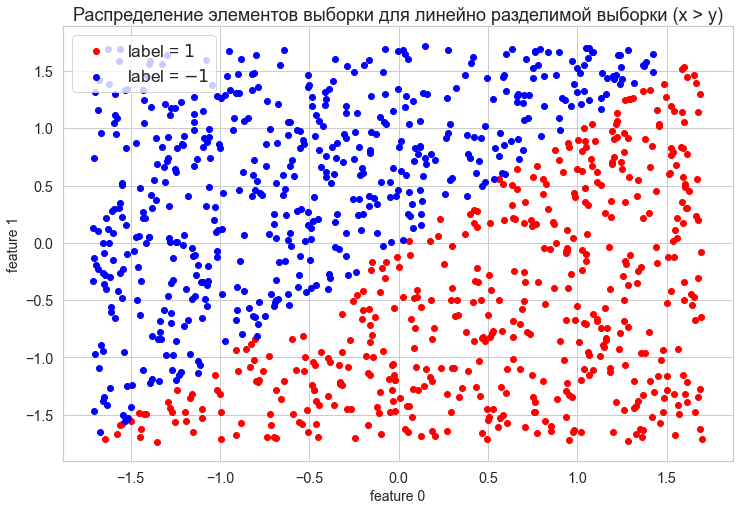

In [222]:
plot_data(X_linear, y_linear, 'Распределение элементов выборки для линейно разделимой выборки (x > y)')

In [223]:
X_circles, y_circles = make_circles(n_samples = 1000, noise = 0.09)
X_circles = preprocessing.scale(X_circles)
y_circles = np.where(y_circles == 0, -1, 1)
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles, y_circles, test_size=0.33, random_state=42)

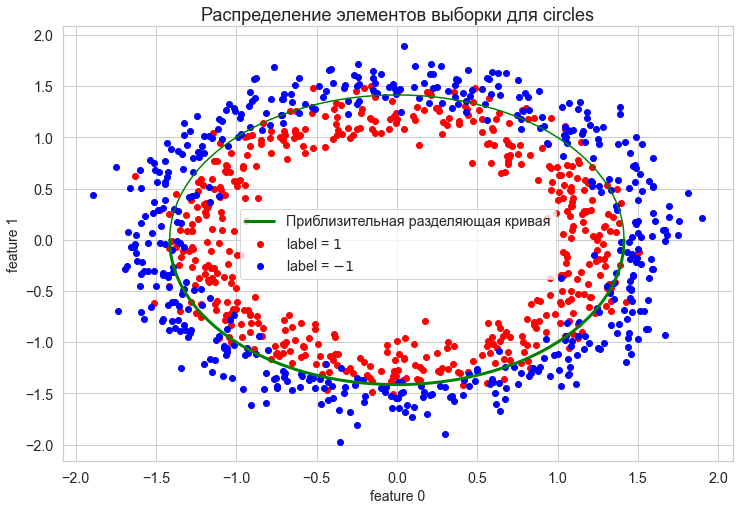

In [224]:
plot_data(X_circles, y_circles, 'Распределение элементов выборки для circles')
r_estimation = 2**0.5
x_grid_tmp = np.linspace(-r_estimation, r_estimation, 1000)
plt.plot(x_grid_tmp, np.sqrt(r_estimation * r_estimation - x_grid_tmp**2), c='g')
plt.plot(x_grid_tmp, -np.sqrt(r_estimation * r_estimation - x_grid_tmp**2), c='g', lw=3, label='Приблизительная разделяющая кривая')
plt.legend()
plt.show()

In [225]:
warnings.filterwarnings('ignore')

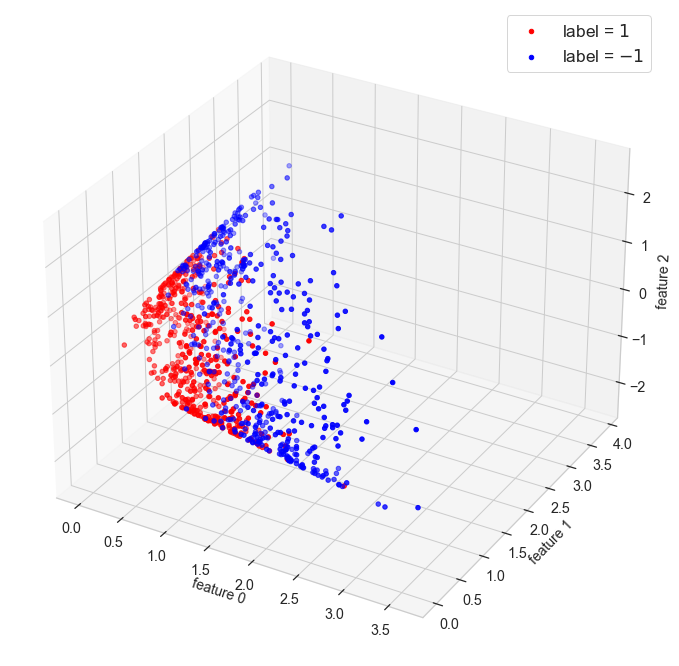

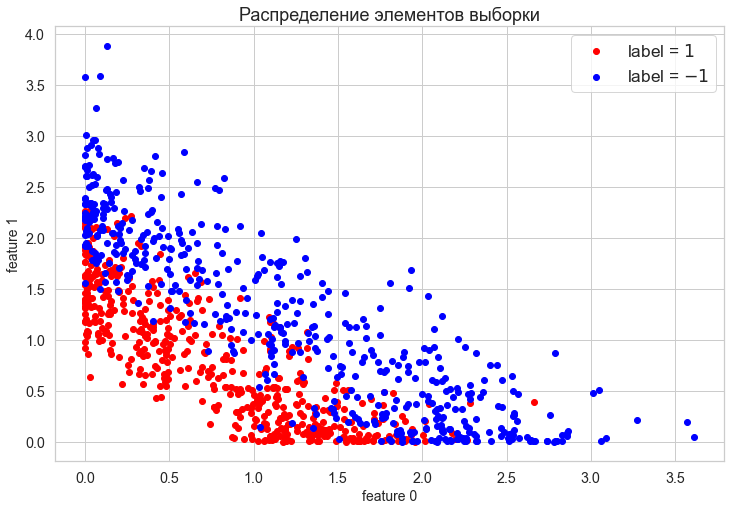

In [226]:
X_poly = np.vstack([X_circles[:, 0]**2, X_circles[:, 1]**2, 2**0.5 * X_circles[:, 0] * X_circles[:, 1]]).T
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_circles, test_size=0.33, random_state=42)
plot_data(X_poly, y_circles, 'Распределение элементов выборки', figsize=(12, 12))
plot_data(X_poly[:,[0,1]], y_circles, 'Распределение элементов выборки', figsize=(12, 8))

In [227]:
X_hastie, y_hastie = make_hastie_10_2(n_samples=1000)
X_hastie = preprocessing.scale(X_hastie)
X_train_hastie, X_test_hastie, y_train_hastie, y_test_hastie = train_test_split(X_hastie, y_hastie, test_size=0.33, random_state=42)

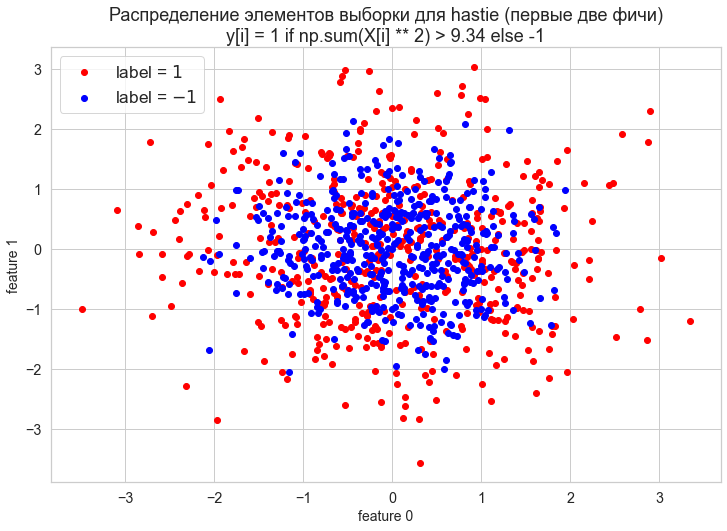

In [228]:
plot_data(X_hastie[:,:2], y_hastie, 'Распределение элементов выборки для hastie (первые две фичи)\n' +
          'y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1')

In [229]:
def polynomial_transformer(X):
    result = np.array([X[:, 0]**2, X[:, 1]**2, 2**0.5 * X[:, 0] * X[:, 1], X[:, 0], X[:, 1], [1] * X.shape[0]]).T
    assert(X.shape[0] == result.shape[0])
    return result

def projection(x1, x2):
    # Проекция вектора x1 на вектор x2
    return x2 * np.dot(x1, x2) / np.dot(x2, x2) 

In [230]:
class SupportVectorMachine:
    def __init__(self, data_transformer=None, kernel_name='default', C=1000, lr=1e-2, max_iter=100):
        # Преобразование, применяемое к входным данным перед работой с ними
        self.data_transformer = data_transformer
        
        kernels = {
            'default': SupportVectorMachine.default_kernel,
            'gaussian': SupportVectorMachine.gaussian_kernel,
            'polynomial': SupportVectorMachine.polynomial_kernel
        }
        
        self.kernel = kernels[kernel_name]
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
    
    @staticmethod
    def default_kernel(X1, X2):
        # Просто скалярное произведение
        a = X1 * X2
        assert(a.shape == X1.shape or a.shape == X2.shape)
        if len(a.shape) > 1:
            result = a.sum(axis=1)
        else:
            result = a.sum()
        return result
    
    @staticmethod
    def gaussian_kernel(X1, X2, sigma_sq=0.1):
        # Гауссово ядро
        return np.exp(-((X1 - X2)**2).sum(axis=1) / (2 * sigma_sq))
    
    @staticmethod
    def polynomial_kernel(X1, X2, k=2):
        # Полиномиальное ядро
        result = (SupportVectorMachine.default_kernel(X1, X2) + 1)**k
        return result
    
    @staticmethod
    def f_dual(lambd, X_train, y_train, kernel):
        # я в градиентном спуске функцию не использую, поэтому её реализация мне не нужна
        return None

    @staticmethod
    def f_dual_grad(lambd, X_train, y_train, C, kernel):
        # Градиент оптимизуремого функционала
        result = -np.ones(lambd.shape)
        for i in range(len(result)):
            delta = (y_train[i] * y_train * lambd * kernel(X_train[i], X_train))
            assert(delta.shape == (X_train.shape[0],))
            delta = delta.sum()
            result[i] += delta
        return result
    
    @staticmethod
    def gradient_descent_advanced(f, gradf, lambd0, X_train, y_train, C, kernel, lr, max_iter=1000, tol=1e-8):        
        # Необходимо поддерживать инвариант: значения x0 находятся от 0 до C, sum y_i x_i = 0
        lambd = lambd0.copy()
        lambd -= projection(lambd, y_train)
        iteration = 0
        conv_array = []

        while True:
            alpha = lr / (iteration + 1)
            gradient = gradf(lambd, X_train, y_train, C, kernel)
            lambd = lambd - alpha * gradient
            iteration += 1
            if np.linalg.norm(gradient) < tol:
                break
            if iteration >= max_iter:
                break

            # lambd = np.maximum(lambd, np.zeros(lambd.shape))
            # lambd = np.minimum(lambd, np.ones(lambd.shape) * C)
            lambd -= projection(lambd, y_train)
            lambd = np.maximum(lambd, np.zeros(lambd.shape))
            lambd = np.minimum(lambd, np.ones(lambd.shape) * C)

            assert(lambd.shape == lambd0.shape)
            conv_array.append(lambd)

        conv_array = np.array(conv_array)
        res = {"x": lambd, "num_iter": iteration, "tol": np.linalg.norm(gradient),  "conv_array": np.array(conv_array)}
        return res
    
    @staticmethod
    def get_w0(lambd, X_train, y_train, kernel):
        # Функция выбирает w0, где провести границу раздела между классами
        best_accuracy = 0
        w0 = 0
        for x in X_train:
            assert(lambd.shape == (X_train.shape[0],))
            assert(y_train.shape == (X_train.shape[0],))
            potential_w0 = (kernel(X_train, x) * lambd * y_train).sum()
            score = 0
            for x1, y1 in zip(X_train, y_train):
                y_pred = np.where((kernel(X_train, x1) * lambd * y_train).sum() - potential_w0 < 0, -1, 1)
                if y_pred == y1:
                    score += 1
            accuracy = score / X_train.shape[0]
            if accuracy > best_accuracy:
                w0 = potential_w0
                best_accuracy = accuracy
        return w0
    
    def fit(self, X_train, y_train):
        if self.data_transformer is not None:
            X_train = self.data_transformer(X_train.copy())
        
        self.X_train = X_train
        self.y_train = y_train
        # self.lambd = np.ones(X_train.shape[0]) / X_train.shape[0]
        self.lambd = np.ones(X_train.shape[0]) * self.C / 2
        res = SupportVectorMachine.gradient_descent_advanced(SupportVectorMachine.f_dual, 
                SupportVectorMachine.f_dual_grad, self.lambd, X_train, y_train, self.C, self.kernel, self.lr, max_iter=self.max_iter)
        self.lambd = res['x']
        self.conv_array = res['conv_array']
        self.w0 = SupportVectorMachine.get_w0(self.lambd, self.X_train, self.y_train, self.kernel)
        # print(f'Получившиеся лямбды: (должны быть > 0), {self.lambd}')
        
    def predict(self, x_test, fixed_w0=None):
        # fixed_w0 is needed for debug purposes
        if self.data_transformer is not None:
            x_test = self.data_transformer(x_test)
        
        # x_test - один элемент, для которого нужно определить класс
        assert(self.lambd.shape == (self.X_train.shape[0],))
        assert(self.y_train.shape == (self.X_train.shape[0],))
        if fixed_w0 is None:
            fixed_w0 = self.w0
        result = np.where((self.kernel(self.X_train, x_test) * self.lambd * self.y_train).sum() - fixed_w0 < 0, -1, 1)
        return result
    
    def get_accuracy(self, X_test, y_test):
        score = 0
        for x_test, actual in zip(X_test, y_test):
            pred = self.predict(x_test.reshape(1, -1))
            if pred == actual:
                score += 1
        return round(score / X_test.shape[0], 4)

### Протестируем наш алгоритм на подготовленных ранее данных

In [231]:
def test_model(X_train, y_train, X_test, y_test, x_grid, y_grid, data_transformer=None, 
               kernel_name='default', C=1000, ax=None, max_iter=100, lr=1e-2, plot_convergence=False):
    # графики только для моделей на двумерных данных
    
    # ax - оси для построения графиков
    need_to_show = False
        
    model = SupportVectorMachine(data_transformer, kernel_name, C=C, lr=lr, max_iter=max_iter)
    model.fit(X_train, y_train)
    
    if X_train.shape[1] == 2:
        if ax is None:
            need_to_show = True
            plt.figure(figsize=(12, 8))
            ax = plt.gca()

        for x in x_grid:
            for y in y_grid:
                new_x = np.array([x, y]).reshape(1, -1)
                pred = model.predict(new_x)
                color = 'r' if pred == 1 else 'b'
                ax.scatter(x, y, c=color)

        title = f'kernel_name: {kernel_name}\n' +\
                '1 класс красный, -1 синий\n' +\
                f'Точность на обучающей выборке: {model.get_accuracy(X_train, y_train)}\n' +\
                f'Точность на тестовой выборке: {model.get_accuracy(X_test, y_test)}'
        ax.set_title(title, fontsize=18)
            
        if need_to_show:
            plt.show()
    else:
        print(f'kernel_name: {kernel_name}\n' +\
                f'Точность на обучающей выборке: {model.get_accuracy(X_train, y_train)}\n' +\
                f'Точность на тестовой выборке: {model.get_accuracy(X_test, y_test)}')
    
    if plot_convergence:
        # график сходимости коэффициентов
        plt.figure(figsize=(12, 8))
        conv_array = model.conv_array
        plt.title(f'Сходимость $\\lambda$ в SVM (kernel: {kernel_name})')
        for i in range(min(len(conv_array[0]), 10)):
            plt.plot(np.arange(len(conv_array)), conv_array[:, i], label=f'$\\lambda_j$')
            plt.legend()
        
    return model

### Датасет с кольцами

In [232]:
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)

In [233]:
all_models = []

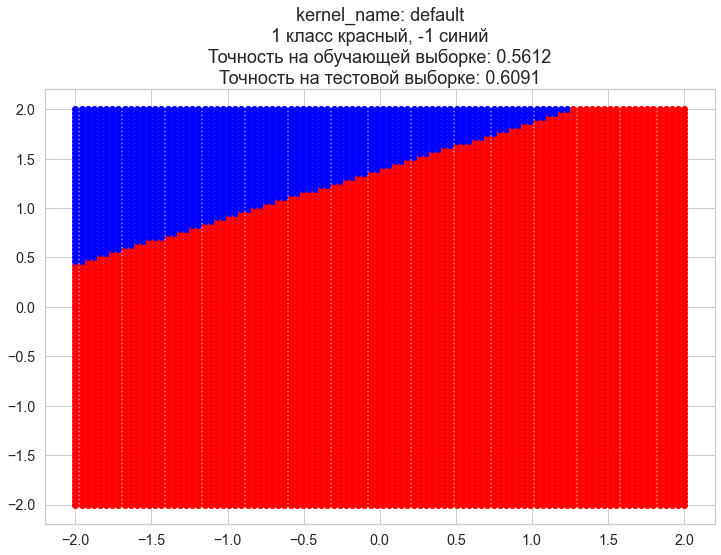

In [234]:
all_models.append({
    'data': 'circles',
    'kernel_name': 'default',
    'model': test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid, kernel_name='default', max_iter=1000)
})

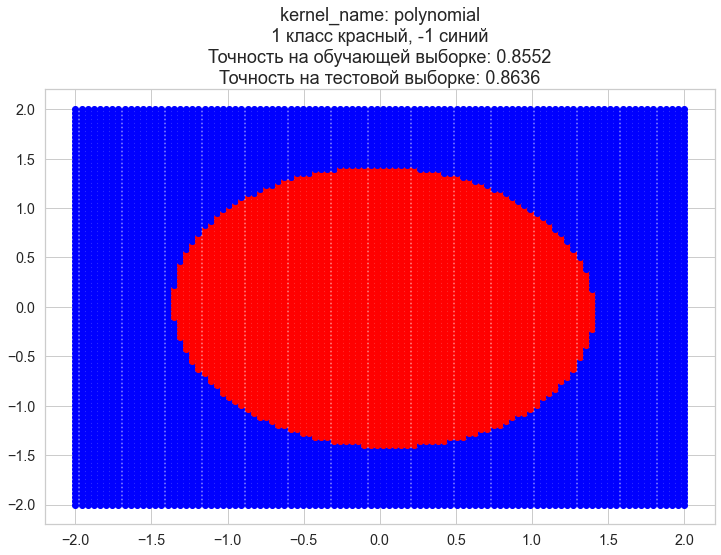

In [235]:
all_models.append({
    'data': 'circles',
    'kernel_name': 'polynomial',
    'model': test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid, kernel_name='polynomial', max_iter=1000)
})

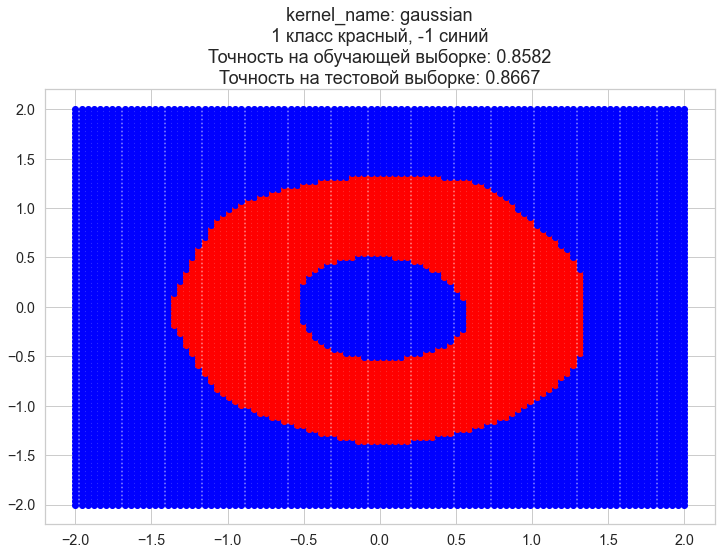

In [236]:
all_models.append({
    'data': 'circles',
    'kernel_name': 'gaussian',
    'model': test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid, kernel_name='gaussian', max_iter=1000)
})

### Линейно разделимый датасет

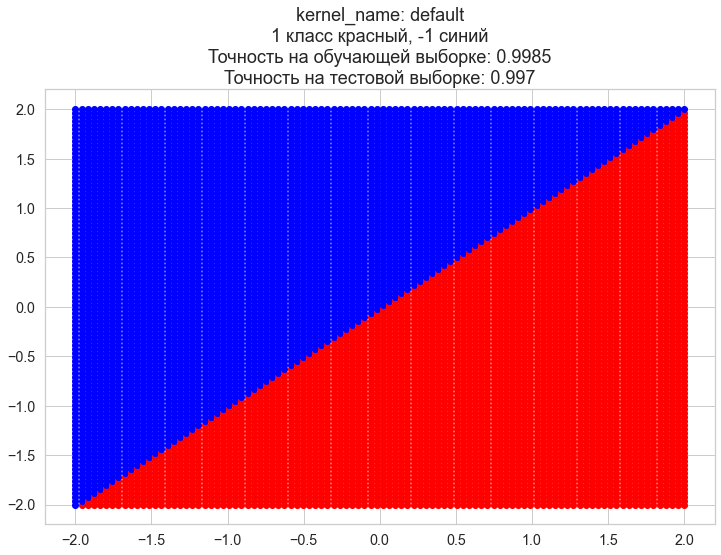

In [238]:
all_models.append({
    'data': 'linear',
    'kernel_name': 'default',
    'model': test_model(X_linear_train, y_linear_train, X_linear_test, y_linear_test, x_grid, y_grid, kernel_name='default', max_iter=1000)
})

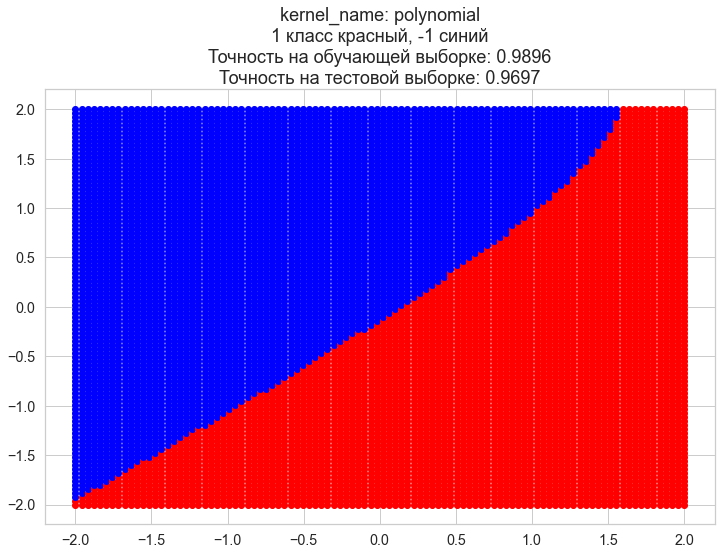

In [239]:
all_models.append({
    'data': 'linear',
    'kernel_name': 'polynomial',
    'model': test_model(X_linear_train, y_linear_train, X_linear_test, y_linear_test, x_grid, y_grid, kernel_name='polynomial', max_iter=1000)
})

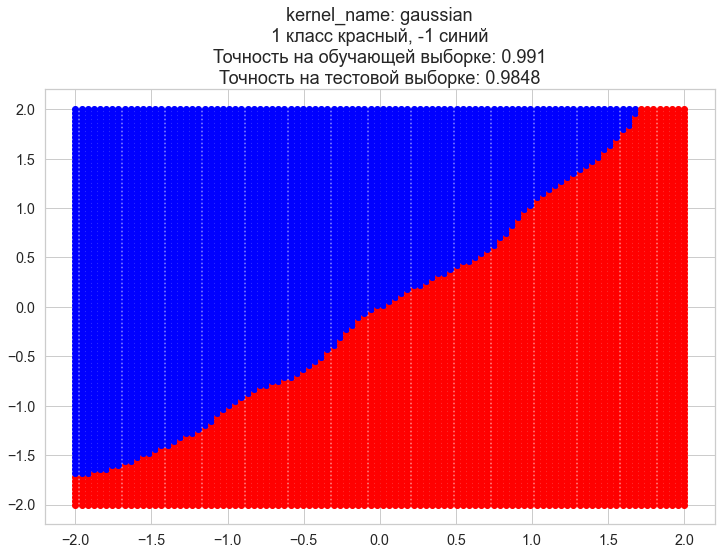

In [240]:
all_models.append({
    'data': 'linear',
    'kernel_name': 'gaussian',
    'model': test_model(X_linear_train, y_linear_train, X_linear_test, y_linear_test, x_grid, y_grid, kernel_name='gaussian', max_iter=1000)
})

###  Датасет с 10 признаками hastie 
(нет визуализации, т.к. 10 признаков, а не 2)

In [241]:
all_models.append({
    'data': 'hastie',
    'kernel_name': 'default',
    'model': test_model(X_train_hastie, y_train_hastie, X_test_hastie, y_test_hastie, x_grid, y_grid, kernel_name='default', max_iter=1000)
})

kernel_name: default
Точность на обучающей выборке: 0.5672
Точность на тестовой выборке: 0.5061


In [242]:
all_models.append({
    'data': 'hastie',
    'kernel_name': 'polynomial',
    'model': test_model(X_train_hastie, y_train_hastie, X_test_hastie, y_test_hastie, x_grid, y_grid, kernel_name='polynomial', max_iter=1000)
})

kernel_name: polynomial
Точность на обучающей выборке: 0.9582
Точность на тестовой выборке: 0.9394


In [243]:
all_models.append({
    'data': 'hastie',
    'kernel_name': 'gaussian',
    'model': test_model(X_train_hastie, y_train_hastie, X_test_hastie, y_test_hastie, x_grid, y_grid, kernel_name='gaussian', max_iter=1000)
})

kernel_name: gaussian
Точность на обучающей выборке: 1.0
Точность на тестовой выборке: 0.5152


**Соберем результаты тестов в одну таблицу:**

|  | Linear | Circles | Hastie |
| --- | --- | --- | --- |
| default | 0.9727 (0.9687) | 0.5636 (0.5746) | 0.5030 (0.5761) |
| polynomial | 0.9970 (0.9970) | 0.8909 (0.8746) | 0.9394 (0.9836) |
| gaussian |  0.9758 (0.9955) | 0.8758 (0.8806) | 0.4636 (1.000) |